# Atividade de Redes Neurais

## Felipe Gibin

## 1. Introdução


O objetivo deste notebook é realizar a classificação estelar com base em suas características espectrais, dividindo-as em três categorias: estrelas, quasares e galáxias, uma atividade fundamental para a astronomia.

Para tal, usaremos o dataset SDSS17, disponível no kaggle pelo [link](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), somado ao framework TensorFlow e bibliotecas do Python

### 1.1 O dataset

O dataset possui diversas features, dentre elas:

1. obj_ID = Identificador do Objeto, o valor único que identifica o objeto no catálogo de imagens usado pelo CAS.

2. alpha = Ângulo de Ascensão Reta (no período J2000).

3. delta = Ângulo de Declinação (no período J2000).

4. u = Filtro Ultravioleta no sistema fotométrico.

5. g = Filtro Verde no sistema fotométrico.

6. r = Filtro Vermelho no sistema fotométrico.

7. i = Filtro Infravermelho próximo no sistema fotométrico.

8. z = Filtro Infravermelho no sistema fotométrico.

9. run_ID = Número de execução usado para identificar a varredura específica.

10. rereun_ID = Número de reanálise para especificar como a imagem foi processada.

11. cam_col = Coluna da câmera para identificar a linha de varredura dentro da execução.

12. field_ID = Número do campo para identificar cada campo observado.

13. spec_obj_ID = ID único usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a mesma classe de saída).

14. class = Classe do objeto (galáxia, estrela ou quasar).

15. redshift = Valor de desvio para o vermelho (redshift) baseado no aumento do comprimento de onda.

16. plate = ID da placa, identifica cada placa no SDSS.

17. MJD = Data Julian Modificada, usada para indicar quando uma determinada peça de dados do SDSS foi coletada.

18. fiber_ID = ID da fibra, que identifica a fibra que direcionou a luz para o plano focal em cada observação.

## 2. Carregamento dos dados e config inicial

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Seeds aleatórias garantem reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

#teste, muda visual dos gráficos
plt.style.use('ggplot')

#carrega dataset
df = pd.read_csv('star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171.0
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427.0
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299.0
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775.0
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842.0


## 3. EDA

### 3.1 Análise Inicial

In [48]:
# Linhas e colunas do dataset
print(df.shape[0])
print(df.shape[1])

50063
18


In [49]:
# Análise inicial
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50063 entries, 0 to 50062
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       50063 non-null  float64
 1   alpha        50063 non-null  float64
 2   delta        50063 non-null  float64
 3   u            50063 non-null  float64
 4   g            50063 non-null  float64
 5   r            50063 non-null  float64
 6   i            50063 non-null  float64
 7   z            50063 non-null  float64
 8   run_ID       50063 non-null  int64  
 9   rerun_ID     50063 non-null  int64  
 10  cam_col      50063 non-null  int64  
 11  field_ID     50063 non-null  int64  
 12  spec_obj_ID  50063 non-null  float64
 13  class        50063 non-null  object 
 14  redshift     50063 non-null  float64
 15  plate        50063 non-null  int64  
 16  MJD          50063 non-null  int64  
 17  fiber_ID     50062 non-null  float64
dtypes: float64(11), int64(6), object(1)
memory usa

class
GALAXY    29427
STAR      11056
QSO        9580
Name: count, dtype: int64


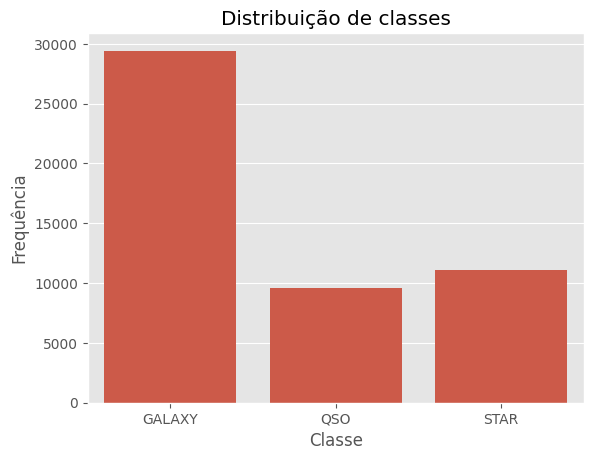

In [50]:
import seaborn as sns

#Distribuição das classes
print(df['class'].value_counts())
sns.countplot(data=df, x='class')
plt.title("Distribuição de classes")
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.show()

### 3.2 Trata outliers

Devido à natureza astronômica das variáveis, que foge ao cotidiano e à familiaridade, é necessário ter mais cautela ao decidir tratar ou não os outliers. Pela análise inicial, observa-se que, em sua maioria, as features apresentam valores de média, máximo e mínimo relativamente próximos, o que sugere ausência de erros de medição. No entanto, há uma variável que foge desse padrão: redshift, cuja média e valor mínimo estão próximos de 0, mas o valor máximo chega a 7. Sendo assim, vamos tratar apenas os outliers dessa variável. Para tal, aplicaremos uma função de capping de (2-93%), tendo em vista que o upper range parece ter mais outliers.

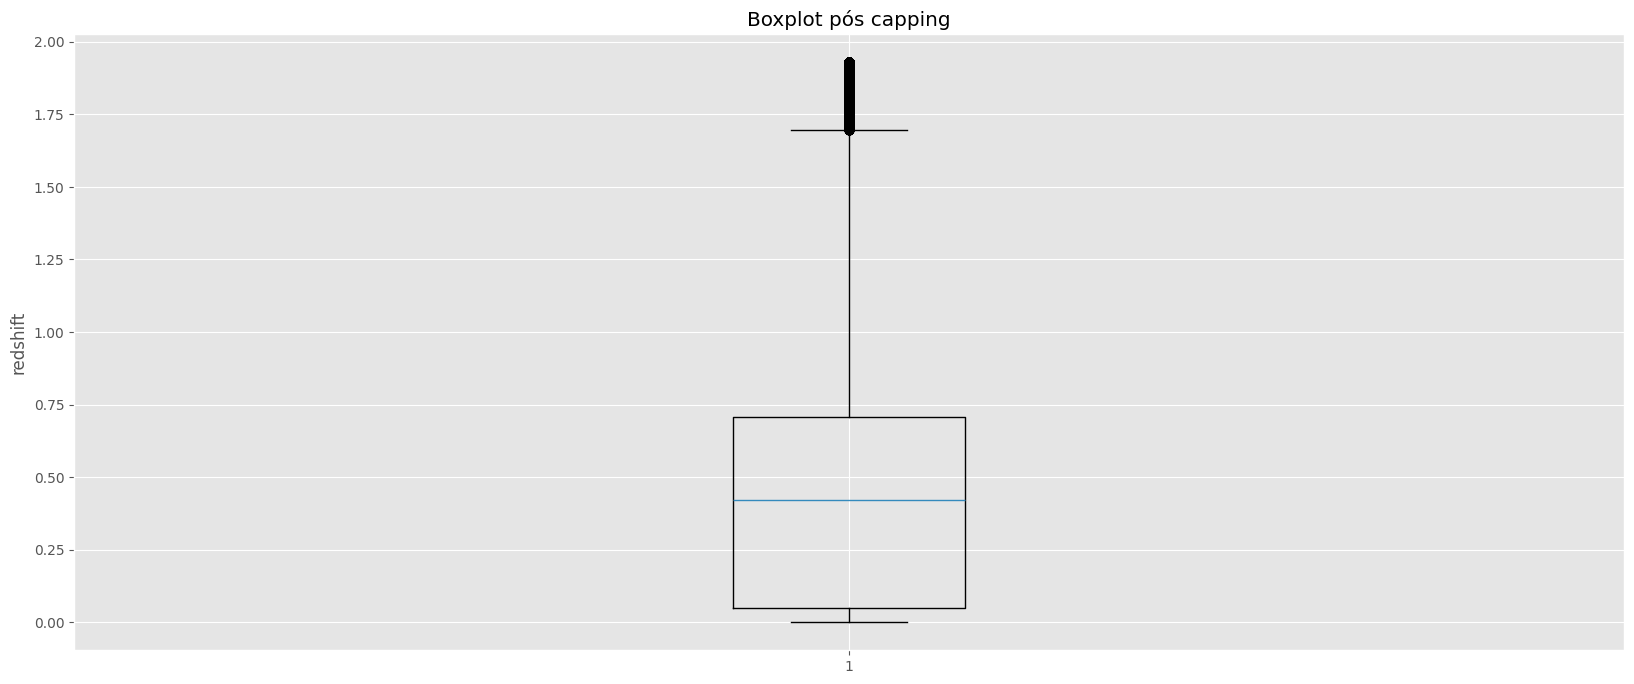

In [51]:
#funcao de capping (2-93%)
def cap_outliers(data, column):
    lower = data[column].quantile(0.02)
    upper = data[column].quantile(0.93)
    data[column] = np.clip(data[column], lower, upper)

cap_outliers(df,'redshift')

#Boxplot pós capping
plt.figure(figsize=(20, 8))
plt.boxplot(df['redshift'])
plt.title("Boxplot pós capping")
plt.ylabel("redshift")
plt.show()

### 3.3 Trata valores faltantes

In [52]:
#Soma os valores zero e NaN por coluna
NaN_values = df.isna().sum()

Zero_values = (df == 0).sum()

# Mostrar resultado
print("Contagem NaN por coluna:")
print(NaN_values)

print("\nContagem zeros por coluna:")
print(Zero_values)

Contagem NaN por coluna:
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       1
dtype: int64

Contagem zeros por coluna:
obj_ID           0
alpha            0
delta            0
u                0
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift       205
plate            0
MJD              0
fiber_ID         0
dtype: int64


Observamos que 'redshift' possui 412 valores nulos, o que corresponde à 0,41% do total de entradas. Dado que essa feature é usada para determinar a distância e velocidade de corpos celestes em relação à Terra, a presença de valores nulos constitui um problema. Apesar da proporção baixa, vamos imputar essas linhas com a mediana para essa variável.

In [53]:
#Mediana de redshift
median_redshift = df['redshift'].median()

# Substitui valores 0 por NaN
df['redshift'] = df['redshift'].replace(0, np.nan)

#Preenche os valores NaN com a mediana
df['redshift'] = df['redshift'].fillna(median_redshift)

### 3.4 Distribuição dos dados numéricos

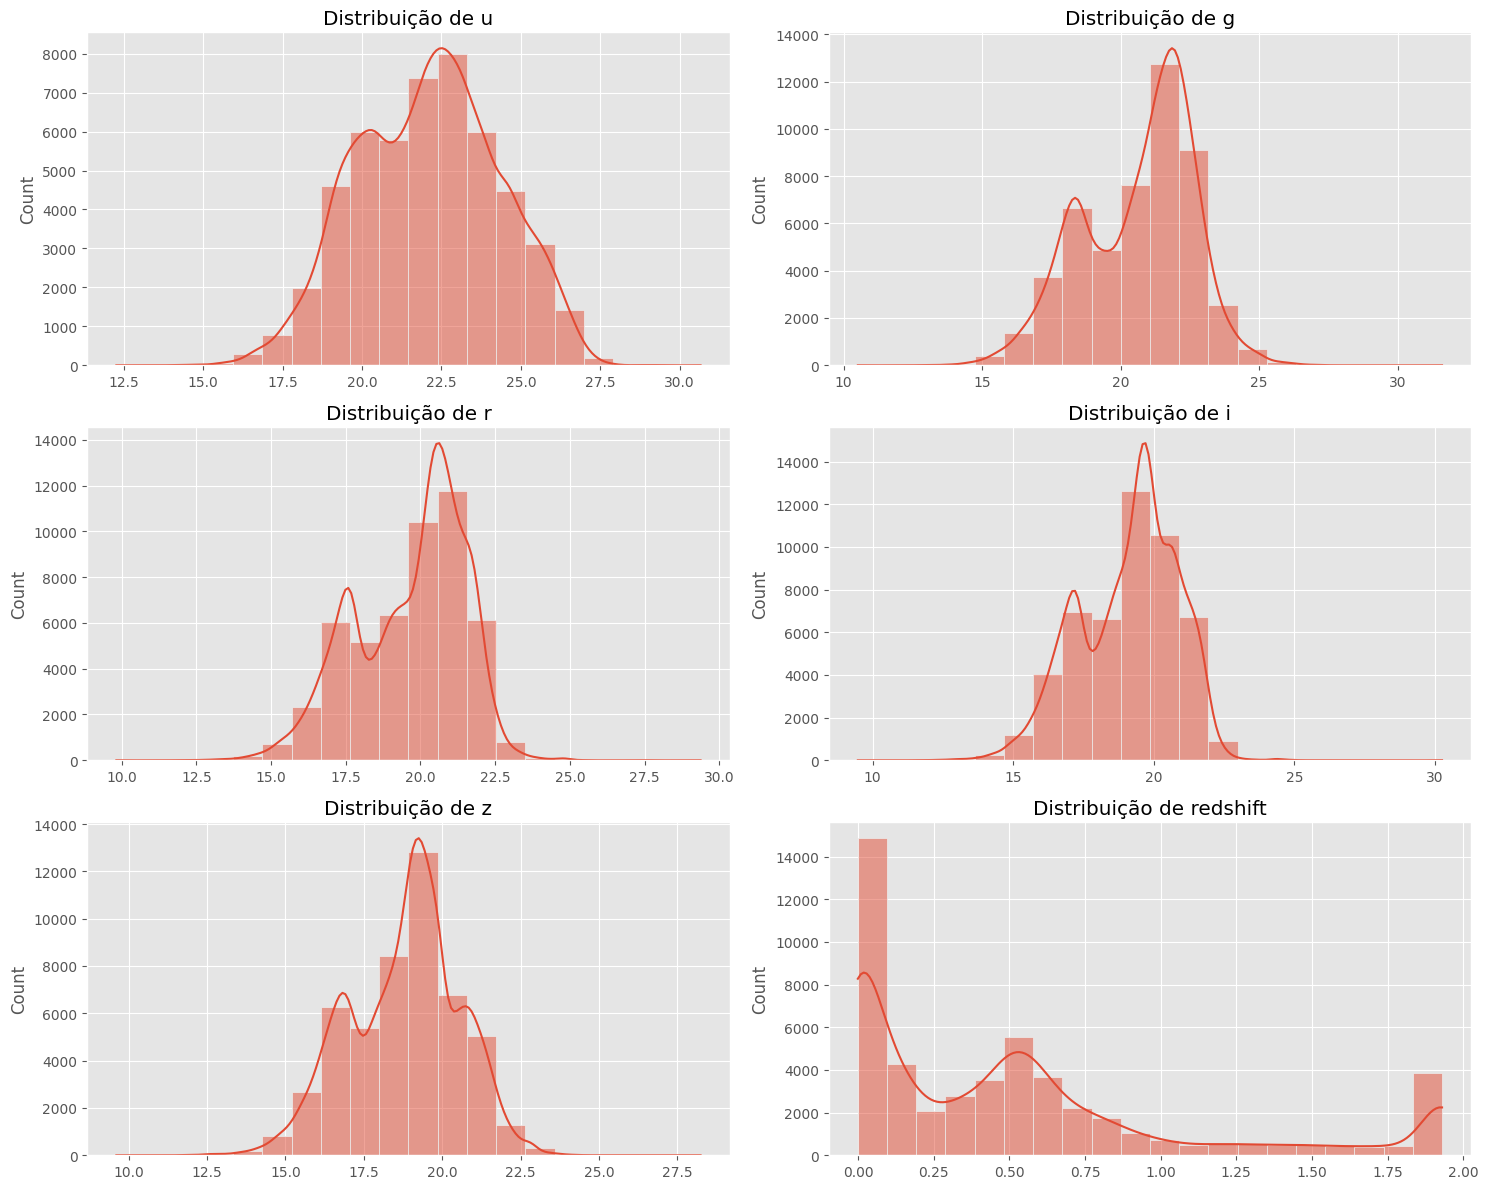

In [55]:
#Colunas relevantes
features = ['u', 'g', 'r', 'i', 'z', 'redshift']
plt.figure(figsize=(15, 12))

# Histogramas com curvas de densidade
for i, var in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[var], kde=True, bins=20)
    plt.title(f'Distribuição de {var}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

Observe que excluímos diversas features dessa distribuição. A seguir, vamos explicar o motivo da exclusão de todas as features afetadas:

1. Todos os IDs. Foram excluídos por se tratarem de rótulos, sem valor preditivo

2. alpha, delta. Coordenadas espaciais do objeto, não interfere na classificação. Inclusive, se mantivéssemos as coordenadas, possívelmente incluiríamos um viés espacial à classificação.

3. cam_col. Metadado de observação, não é importante

4. plate, MJD. Informações sobre a placa de espectografia e data de observação, não influenciam na classificação.



## 4. Pré processamento dos dados

Para a tarefa de classificação, fica interessante codificar as classes em one hot, além de normalizar as features relevantes.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Lembrando que features = ['u', 'g', 'r', 'i', 'z', 'redshift']
X = df[features]
y = df['class']

#Codifica as classes em one hot
y = pd.get_dummies(y, drop_first=False) #drop_first = True é interessante para evitar colineridade, n se aplica aqui

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar apenas os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Treinando um MLP

Para essa tarefa, definiremos um modelo de MLP (Multi Layer Perceptron).





EXPLICAR, SOFTMAX, CAMADAS, COMO FUNCIONA, ETC

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP.evaluate(X_test, y_test)

Epoch 1/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8560 - loss: 0.4044 - val_accuracy: 0.9613 - val_loss: 0.1534
Epoch 2/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9559 - loss: 0.1463 - val_accuracy: 0.9660 - val_loss: 0.1218
Epoch 3/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9639 - loss: 0.1192 - val_accuracy: 0.9678 - val_loss: 0.1112
Epoch 4/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9665 - loss: 0.1091 - val_accuracy: 0.9695 - val_loss: 0.1052
Epoch 5/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9681 - loss: 0.1038 - val_accuracy: 0.9709 - val_loss: 0.1009
Epoch 6/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9689 - loss: 0.0997 - val_accuracy: 0.9708 - val_loss: 0.0985
Epoch 7/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9699 - loss: 0.0967 - val_accuracy: 0.9719 - val_loss: 0.0963
Epoch 8/20
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9705 - loss: 0.0944 - 

In [66]:
print("\nAvaliação no conjunto de teste:")
test_loss, test_acc = model_MLP.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no teste: {test_acc:.4f}")


Avaliação no conjunto de teste:
Acurácia no teste: 0.9757
